# Sticker Sales Forecasting with Modal and BentoML

## Background

In January 2025, [Kaggle](https://www.kaggle.com/competitions/playground-series-s5e1/overview) ran a playground series competition to forecast mulitple years worth of sticker sales in different countries. For each id row, you have to predict the num_sold which represents the number of sticker sold.

This notebook demonstrates how to build and deploy a machine learning solution for forecasting sticker sales using Modal (for serverless compute) and BentoML (for model management).

NB: The data for this comepeition was synthentically generated but was made to contain real world patterns and effects that you might see in real data such as seasonality, weekend and holiday effect, etc.

In this project, we'll build an end-to-end solution for forecasting sticker sales across different stores and countries. We'll use:

- **XGBoost**: For the regression model
- **FastAI**: For data preprocessing
- **Modal**: For serverless compute and API hosting
- **BentoML**: For model management

The solution will allow us to:
1. Upload training data to Modal's cloud storage
2. Train a model in Modal's cloud environment
3. Deploy a prediction API endpoint
4. Make forecasts via API calls

### Evaluation

The competiton submission were evaluated on the [Mean Absolute Percentage Error (MAPE).](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) metric which expresses the average absolute error as a percentage of the actual values, making it easy to understand the relative size of errors For example, if you predict a value of 90 when the actual is 100, the percentage error is 10%, but if you predict 110 when the actual is 100, the percentage error is also 10%. MAPE averages these absolute percentage errors across all observations.

Let's get started!

### Pip install dependencies

Here we install the dependencies needed for us to run our code below

In [31]:
#| code-fold: true
#| output: false
#| code-summary: "Library Installation"


%pip install catboost
#%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
%pip install polars
%pip install tqdm
#%pip install wandb
#%pip install sweetviz
#%pip install --upgrade scipy
%pip install gradio
%pip install dash
%pip install streamlit plotly requests
%pip install boto3
%pip install modal bentoml 
%pip install streamlit pandas requests plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

### Imports

In [32]:
#|include: false 
#|hide_metadata
#| code-fold: true
#| output: false
#| code-summary: "Library Import"

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
#from fastkaggle import setup_comp
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import LinearRegression

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,Pool, metrics, cv


import warnings


matplotlib.rc('image', cmap='Greys')
import scipy.stats as stats



#import h2o
#from h2o.automl import H2OAutoML

import gc
#import wandb

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

import dash
from dash import dcc, html, dash_table

import boto3
import io
import getpass
import json

from joblib import dump, load
import typing as t
import bentoml
from bentoml.validators import DataframeSchema

import modal

# Extract, Load and Transform

I use [airbyte](https://airbyte.com/) which is an open source tool that can be used to extract and load data from one source to another, building data pipelines.

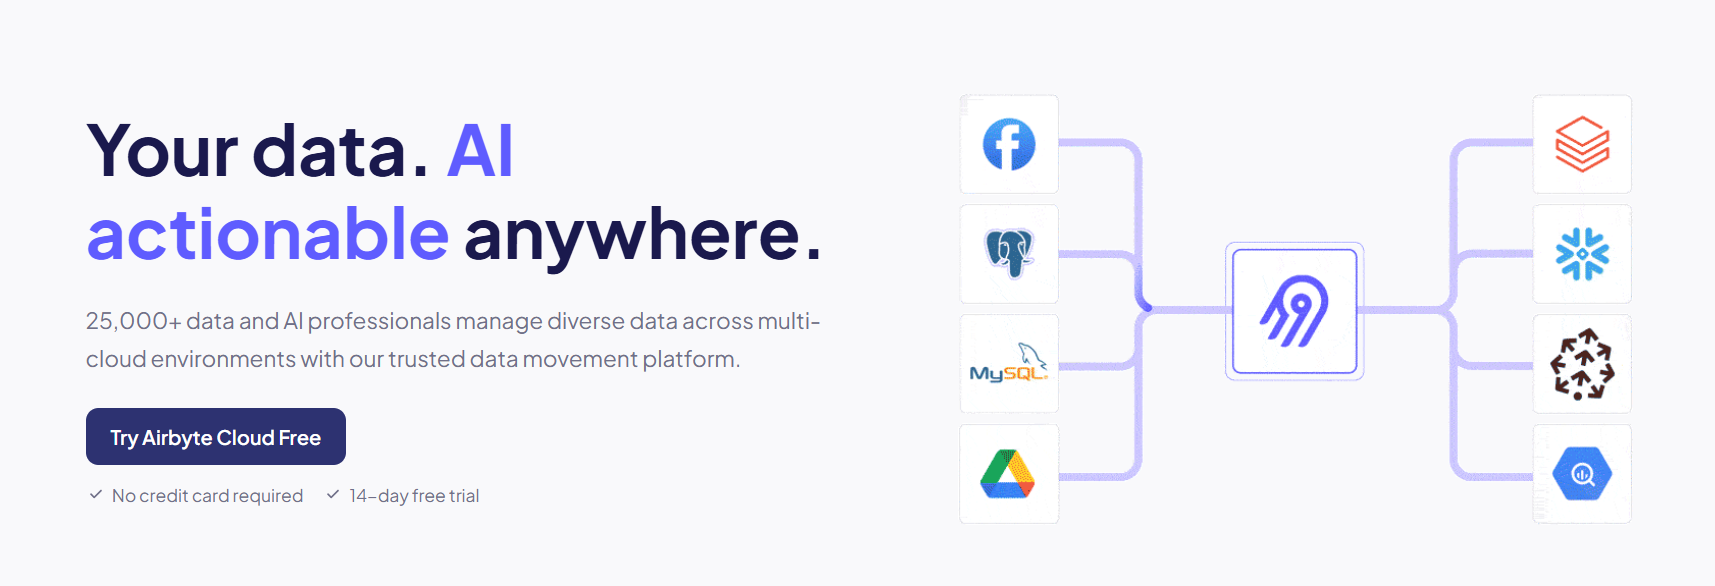

To demonstrate this in our example, we uploaded our training csv data into a google sheet and then pulled it aws s3. After this, we load this dataset into our training enviroment as shown below.

In [7]:
#| include: false
#| code-fold: true
#| output: false
#| code-summary: "AWS Authentication"

# Get AWS credentials securely through interactive input
aws_access_key = input("Enter your AWS access key: ")
aws_secret_key = getpass.getpass("Enter your AWS secret key: ")

# Create S3 client with user-provided credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

# Now you can use s3_client as before
# For example:
# response = s3_client.get_object(Bucket='your-bucket', Key='your-file.csv')
# df = pd.read_csv(io.BytesIO(response['Body'].read()))

In [ ]:
# Method 1: Download file to local and then read
s3_client.download_file('flexible-functions', 'sticker-sales/train.csv/ss_train.csv', 'local_filename_ss.csv')
df = pd.read_csv('local_filename_ss.csv')

In [ ]:
!ls

LICENSE		data		       s05e01-gbms-fastai-preprocessing.ipynb
README.md	gradio_ui	       service.py
__pycache__	load_save.py	       streamlit_ui
airbyte.ipynb	local_filename_ss.csv  test.py
bentofile.yaml	requirements.txt


In [ ]:
train_df = pd.read_csv('local_filename_ss.csv')

In [ ]:
train_df

,_airbyte_raw_id,_airbyte_extracted_at,_airbyte_meta,_airbyte_generation_id,_airbyte_data
0,6d6c8062-482a-4b5a-aaa6-dea1c916be45,1742174334284,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""0"",""date"":""2010-01-01"",""country"":""Canada"",""store"":""Discount Stickers"",""product"":""Holographic Goose""}"
1,8d798e53-1322-4db0-a88b-e4eeb7357bb4,1742174334284,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""1"",""date"":""2010-01-01"",""country"":""Canada"",""store"":""Discount Stickers"",""product"":""Kaggle"",""num_sold"":""973""}"
2,33e1611d-353c-4de3-bc18-4ba1dc512679,1742174334284,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""2"",""date"":""2010-01-01"",""country"":""Canada"",""store"":""Discount Stickers"",""product"":""Kaggle Tiers"",""num_sold"":""906""}"
3,240d36b1-a1c8-4c3f-8d9d-63a65f7312e8,1742174334284,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""3"",""date"":""2010-01-01"",""country"":""Canada"",""store"":""Discount Stickers"",""product"":""Kerneler"",""num_sold"":""423""}"
4,6587ddb0-75ca-42cb-8b32-e884e31421e0,1742174334284,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""4"",""date"":""2010-01-01"",""country"":""Canada"",""store"":""Discount Stickers"",""product"":""Kerneler Dark Mode"",""num_sold"":""491""}"
...,...,...,...,...,...
230125,c7c85a06-c777-475f-b224-8a99bd983e8d,1742174354680,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""230125"",""date"":""2016-12-31"",""country"":""Singapore"",""store"":""Premium Sticker Mart"",""product"":""Holographic Goose"",""num_sold"":""466""}"
230126,af6cbb79-e2a6-45c4-badf-59f069dd3c0a,1742174354680,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""230126"",""date"":""2016-12-31"",""country"":""Singapore"",""store"":""Premium Sticker Mart"",""product"":""Kaggle"",""num_sold"":""2907""}"
230127,9e5a4a1e-a624-40ae-b588-4420f9bcd02a,1742174354680,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""230127"",""date"":""2016-12-31"",""country"":""Singapore"",""store"":""Premium Sticker Mart"",""product"":""Kaggle Tiers"",""num_sold"":""2299""}"
230128,c9688c3f-5feb-47fb-996f-03df6ecfb7e6,1742174354680,"{""sync_id"":30952774,""changes"":[]}",1,"{""id"":""230128"",""date"":""2016-12-31"",""country"":""Singapore"",""store"":""Premium Sticker Mart"",""product"":""Kerneler"",""num_sold"":""1242""}"


Our data is in the _airbyte_data column, so lets go ahead and extract it. We have a few ways we can do this.

# Approach 1

In [ ]:
# Assuming train_df is already loaded with your data
# Extract the JSON blobs from the '_airbyte_data' column
data = train_df['_airbyte_data'].apply(json.loads)

# Convert the extracted JSON data into a DataFrame
extracted_df = pd.json_normalize(data)

# Save the extracted DataFrame to a CSV file
extracted_df.to_csv("output.csv", index=False)

print("Data successfully extracted and saved to output.csv")


Data successfully extracted and saved to output.csv


In [ ]:
output_df = pd.read_csv('output.csv')
output_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


## Approach 2 

We can load our data in a more optimal way. Lets do that below

In [ ]:
def transform_airbyte_data(input_file, output_file):
    """
    Transform Airbyte raw data format back to original tabular format
    
    Parameters:
    input_file (str): Path to the input file (CSV or JSON) from Airbyte
    output_file (str): Path to save the transformed CSV file
    
    Returns:
    pd.DataFrame: The transformed DataFrame
    """
    file_ext = os.path.splitext(input_file)[1].lower()
    
    # Read the data based on file type
    if file_ext == '.csv':
        df = pd.read_csv(input_file)
    elif file_ext == '.json':
        df = pd.read_json(input_file, lines=True)  # Assuming JSONL format
    else:
        raise ValueError(f"Unsupported file extension: {file_ext}. Use .csv or .json")
    
    # Check if the data is in Airbyte format
    airbyte_columns = [col for col in df.columns if col.startswith('_airbyte_')]
    
    if '_airbyte_data' in df.columns:
        # If _airbyte_data is a string column, parse it to dictionaries
        if df['_airbyte_data'].dtype == 'object' and isinstance(df['_airbyte_data'].iloc[0], str):
            df['_airbyte_data'] = df['_airbyte_data'].apply(json.loads)
        
        # Extract the data from _airbyte_data column
        extracted_data = pd.json_normalize(df['_airbyte_data'])
        
        # Convert numeric columns if needed
        for col in extracted_data.columns:
            if col in ['id', 'num_sold']:
                try:
                    extracted_data[col] = pd.to_numeric(extracted_data[col])
                except:
                    pass  # Keep as string if conversion fails
                    
        # Save the result
        extracted_data.to_csv(output_file, index=False)
        print(f"Transformed data saved to {output_file}")
        
        return extracted_data
    else:
        print("Data doesn't appear to be in Airbyte format. No transformation needed.")
        df.to_csv(output_file, index=False)
        return df


In [ ]:
# Example usage
if __name__ == "__main__":
    # Replace with your actual file paths
    input_file = "local_filename_ss.csv"  # or .json
    output_file = "transformed_data.csv"
    
    transformed_df = transform_airbyte_data(input_file, output_file)
    print(transformed_df.head())

Transformed data saved to transformed_data.csv
   id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0


In [ ]:
!ls

LICENSE		gradio_ui				service.py
README.md	load_save.py				streamlit_ui
__pycache__	local_filename_ss.csv			test.py
airbyte.ipynb	output.csv				transformed_data.csv
bentofile.yaml	requirements.txt
data		s05e01-gbms-fastai-preprocessing.ipynb


### Load data

We only did ELT job for the training dataset for demonstration, for the test and sample submission file, we shall load them from the local files.

In [ ]:
path = Path('')
path

Path('.')

In [ ]:
train_df = pd.read_csv('transformed_data.csv',index_col='id')
test_df = pd.read_csv(path/'data/test.csv',index_col='id')
sub_df = pd.read_csv(path/'data/sample_submission.csv')

## Exploratory Data Analysis

In [ ]:
train_df.columns

Index(['date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [ ]:
train_df

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0


In [ ]:
test_df

,date,country,store,product
id,,,,
230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
230131,2017-01-01,Canada,Discount Stickers,Kaggle
230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
230133,2017-01-01,Canada,Discount Stickers,Kerneler
230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...
328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers


In [ ]:
train_df.shape,test_df.shape

((230130, 5), (98550, 4))

#### Categorical Data

In [ ]:
train_df.describe(include=[object]).T

,count,unique,top,freq
date,230130,2557,2010-01-01,90
country,230130,6,Canada,38355
store,230130,3,Discount Stickers,76710
product,230130,5,Holographic Goose,46026


In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_sold,221259.0,752.527382,690.165445,5.0,219.0,605.0,1114.0,5939.0


#### Missing Values

In [ ]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

num_sold    8871
date           0
country        0
store          0
product        0
dtype: int64


The training data seems to range from 1st Jan 2010 to 31st Dec 2016, while the test set ranges from 2017 to 2019.

All the features except date seem to be categorical, i.e., there are 6 countries, 3 different types of stores, and 5 products.

Only the target variable contains missing values. We shall handle these later on in the notebook. This is similar to the previous tabular playground series competition, which had missing values in the target.

There is the same number of stores in the different countries.

#### Check for encoding

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      230130 non-null  object 
 1   country   230130 non-null  object 
 2   store     230130 non-null  object 
 3   product   230130 non-null  object 
 4   num_sold  221259 non-null  float64
dtypes: float64(1), object(4)
memory usage: 10.5+ MB


#### Country

In [ ]:
counts = train_df['country'].unique()
print(counts)

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']


In [ ]:
counts = train_df['country'].value_counts(dropna=False)
print(counts)

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64


In [ ]:
train_df.country.value_counts(normalize=True)

country
Canada       0.166667
Finland      0.166667
Italy        0.166667
Kenya        0.166667
Norway       0.166667
Singapore    0.166667
Name: proportion, dtype: float64

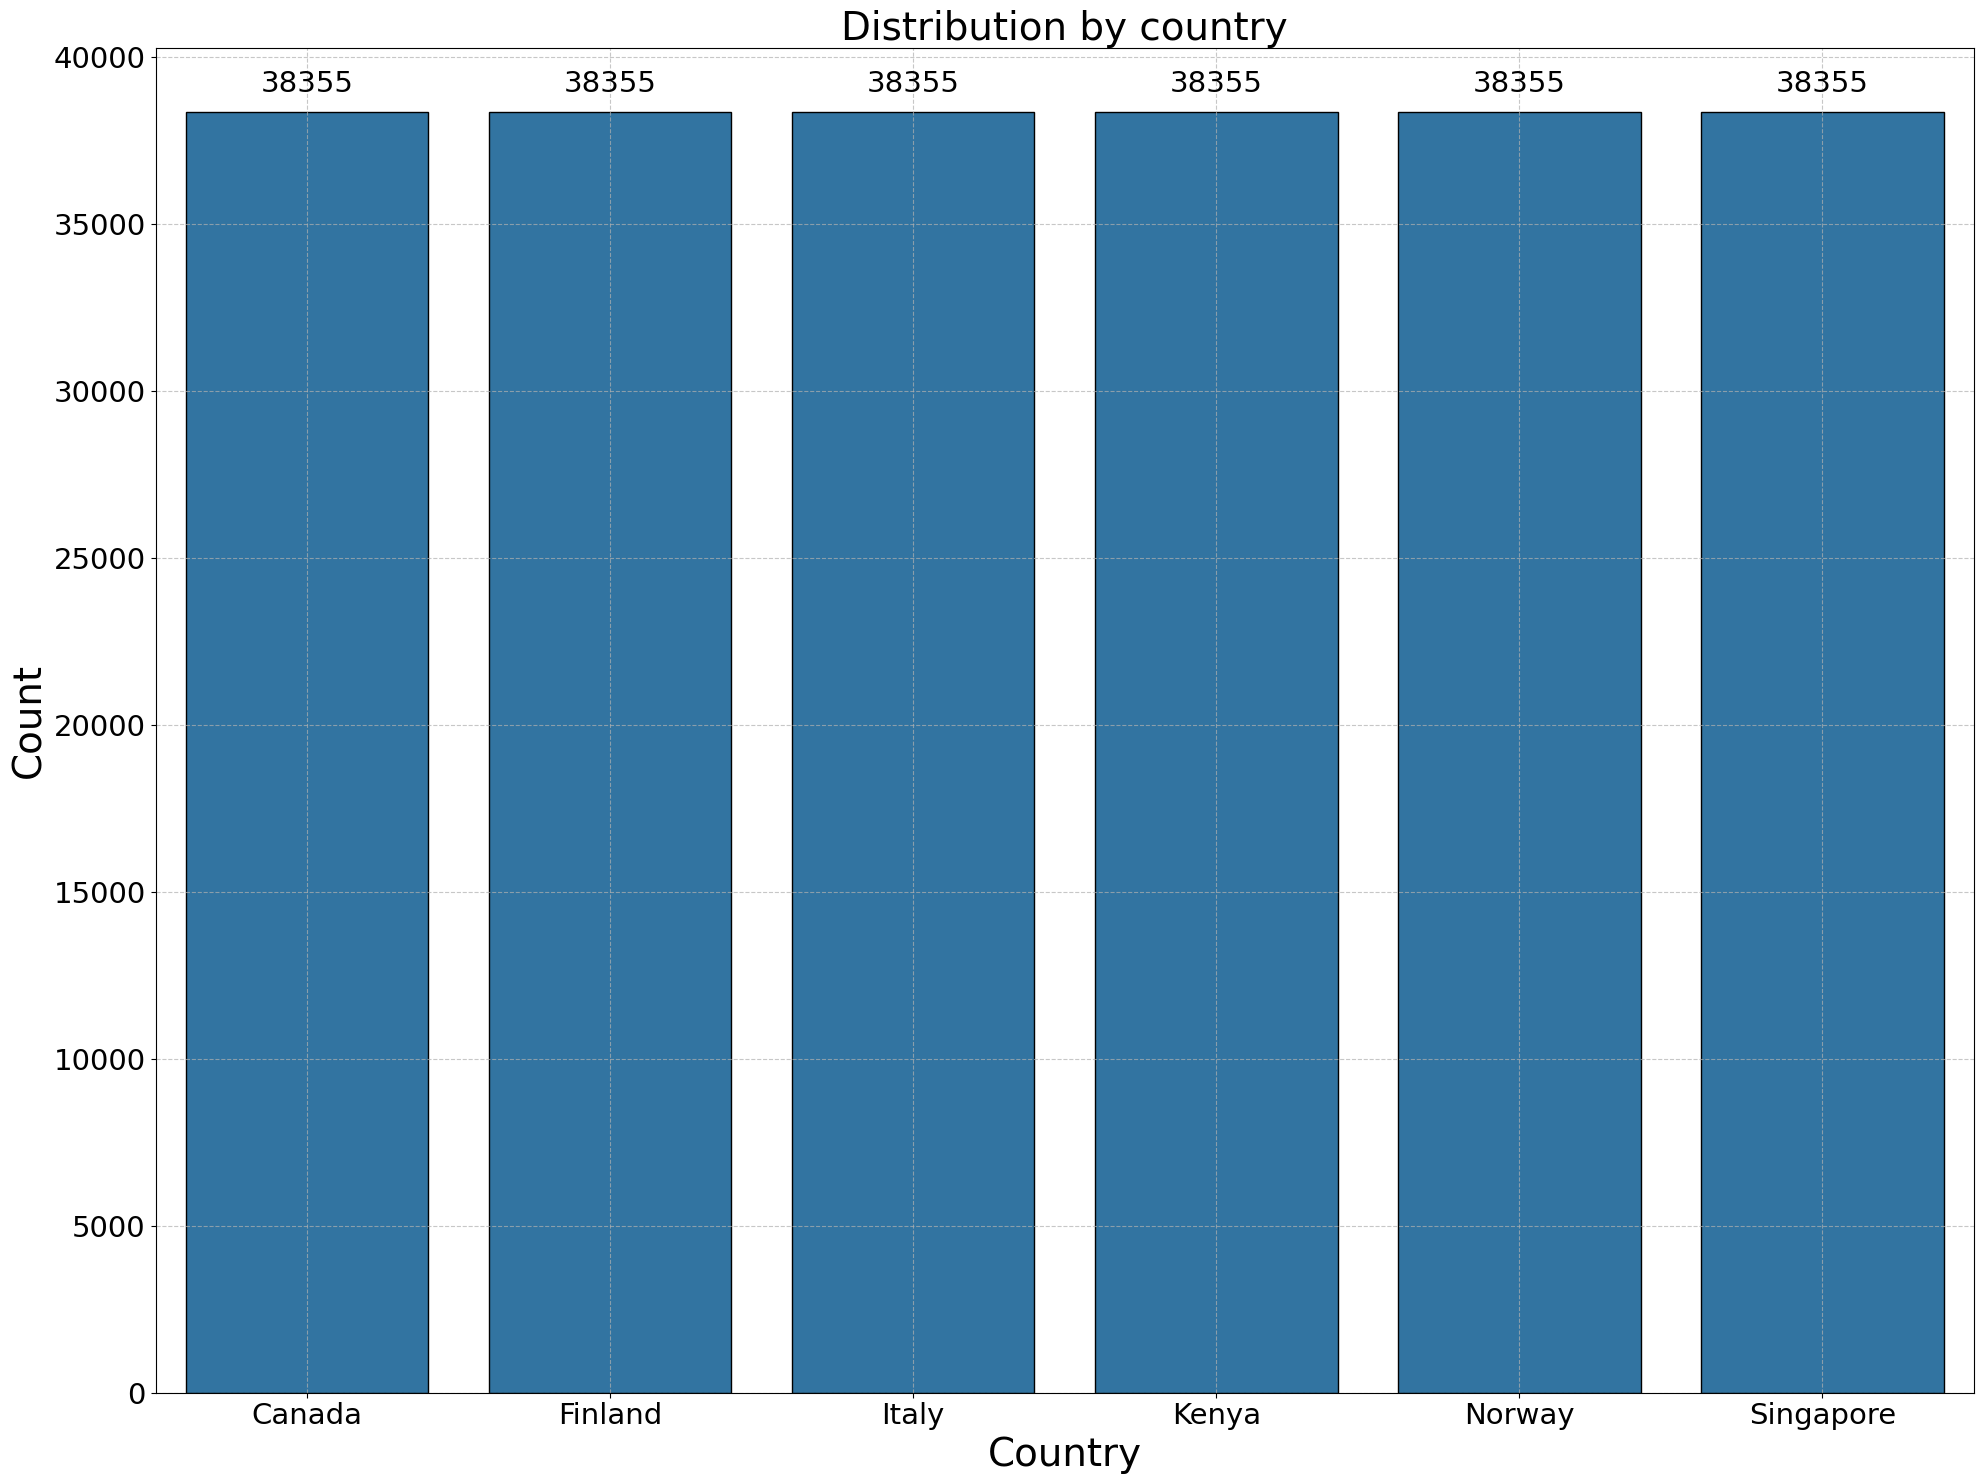

In [ ]:
plt.figure(figsize=(20, 15))

# Create the countplot
ax = sns.countplot(x='country',edgecolor='black', data=train_df)

plt.title('Distribution by country', fontsize=28)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Country', fontsize=28)
plt.ylabel('Count', fontsize=28)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

# Get the current axis
ax = plt.gca()

# Add value annotations to each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=21, padding=10)

plt.tight_layout()
plt.show()

#### Sales by country

<Axes: xlabel='country', ylabel='num_sold'>

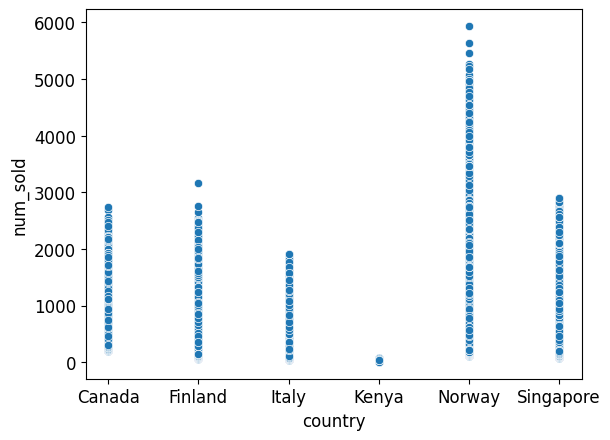

In [ ]:
sns.scatterplot(data=train_df, x='country', y='num_sold')

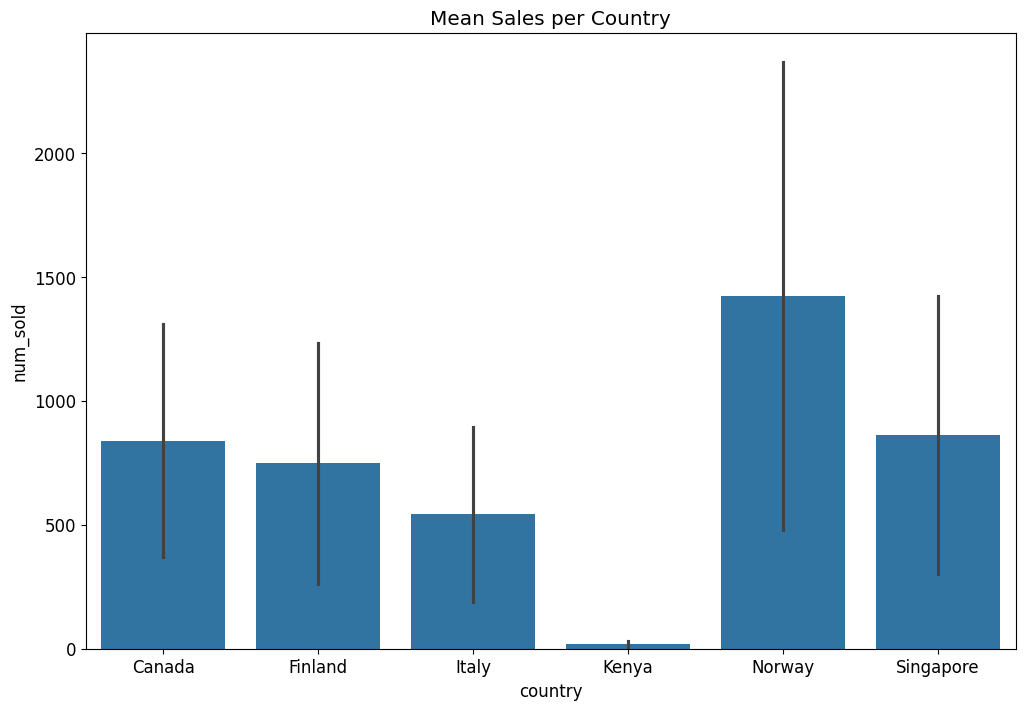

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='country', y='num_sold', errorbar='sd', data=train_df)
plt.title('Mean Sales per Country')
plt.show()


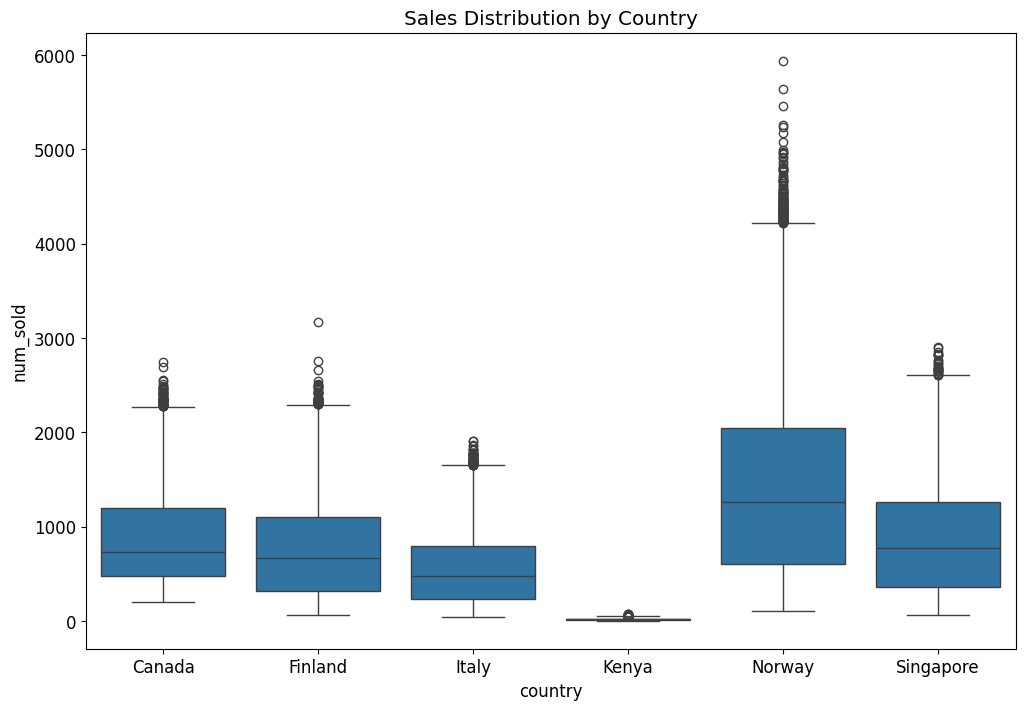

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='country', y='num_sold', data=train_df)
plt.title('Sales Distribution by Country')
plt.show()

## Model serving and deployment using [BentoML](https://docs.bentoml.com/en/latest/index.html) and [Modal](https://modal.com/). 

BentoML is a service we can use to manage, serve and deploy machine learning models to an API. 

Modal is a serveless cloud platform that enables us to run and execute any python code in the cloud without having to manage infrastructure.Modal makes it easy to attach GPU'S with just one line of code and can serve our functions as web endpoints.

I previously showed how to train, serve and deploy a machine learning model to a live API endpoint with bentoml and bentocloud [here](https://nbsanity.com/static/ac40bb062434c7446906d3eb8875e061/load.html). For this project, i will be using bentoml for model management i.e. model loading and saving while i shall be running my model training, serving and endpoint deployment using Modal.

So in this project, we'll build an end-to-end solution for forecasting sticker sales across different stores and countries. We'll use:

- **XGBoost**: For training our regression model
- **FastAI**: For data preprocessing
- **Modal**: For serverless compute and API hosting
- **BentoML**: For model management

The solution will allow us to:
1. Upload training data to Modal's cloud storage
2. Train a model in Modal's cloud environment
3. Deploy a prediction API endpoint
4. Make forecasts via API calls

Let's get started!

### Project Setup <a name="project-setup"></a>

First, we need to set up our environment. To do this, run ```modal setup``` via your terminal.

This returns the below.

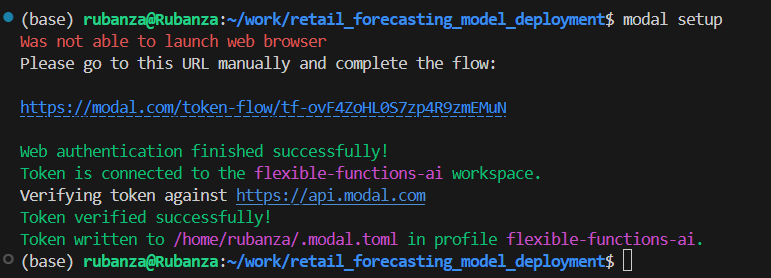

In [ ]:
# Initialize Modal (one-time setup)
#!modal setup

So, we can now create a project directory with the below structure:

```
retail_forecasting_modal/
├── data/                 # Local directory for CSV files
│   ├── train.csv
│   └── test.csv
├── modal_upload.py       # Data upload script
├── modal_train.py        # Model training script
├── modal_serve.py        # API serving script
├── test_modal_api.py     # API testing script
└── requirements.txt      # Project dependencies, not neccesary for modal though
```



## Data Upload <a name="data-management"></a>


In [33]:
import modal

In [34]:
# Create an app for the data upload
app = modal.App("sticker-data-upload")

This initializes a Modal application named "sticker-data-upload". Modal is a cloud platform that lets you run Python functions in the cloud. 

The App class is used to define a Modal application which is just a group of functions and classes that are deployed together.

In [35]:
# Create a volume to persist data
volume = modal.Volume.from_name("sticker-data-volume", create_if_missing=True)

So we start by uploading our data to Modal using [volumes](https://modal.com/docs/guide/volumes). To quote the modal documentation

> Modal Volumes provide a high-performance distributed file system for your Modal applications. They are designed for write-once, read-many I/O workloads, > like creating machine learning model weights and distributing them for inference.

This will enable our training function that we run later to access the data it will need to train our machine learning model.

NB: You can achieve the same data upload functionality using Modal [Images](https://modal.com/docs/guide/images) by using the image.add_local_dir and image.add_local_file image builder methods. This can be done by creating an image that has our data like below

```
sticker_data_image = (
    modal.Image.debian_slim()
    .pip_install(["pandas", "numpy", "xgboost", "bentoml"])
    # Add your local data directory to the image
    .add_local_dir("./data", remote_path="/data")
)
```

For this example, I shall be uploading my data using Modal volumes as opposed to using images. 

This creates a persistent storage volume in Modal named "sticker-data-volume". The ```create_if_missing=True``` flag means it will create the volume if it doesn't already exist. Volumes in Modal are like shared disk space that can persist between function runs.

Remember our modal app can consist of various functions and classes. To explicity register an object with the app, we use the ```@app.function()``` decorator.Below we define a function called ```upload_data``` to upload our data.

In [36]:
@app.function(volumes={"/data": volume})
def upload_data(local_data_path):
    import shutil
    import os
    
    # Ensure the destination directory exists
    os.makedirs("/data", exist_ok=True)
    
    # Copy all files from the local data directory to the volume
    for file in Path(local_data_path).glob("*"):
        dest = f"/data/{file.name}"
        if file.is_file():
            shutil.copy(file, dest)
            print(f"Copied {file} to {dest}")
    
    # List files to confirm upload
    print("\nFiles in Modal volume:")
    for file in Path("/data").glob("*"):
        print(f" - {file}")


/tmp/ipykernel_588051/3096769847.py:2: DeprecationError: 2025-02-03: Modal will stop implicitly adding local Python modules to the Image ("automounting") in a future update. The following modules need to be explicitly added for future compatibility:
* _remote_module_non_scriptable

e.g.:
image_with_source = my_image.add_local_python_source("_remote_module_non_scriptable")

For more information, see https://modal.com/docs/guide/modal-1-0-migration
  def upload_data(local_data_path):


Inside the function, We import the necessary modules and ensure the destination directory exists. The ```exist_ok=True``` means it won't raise an error if the directory already exists.

I then loop through all files in the specified local directory, copy each file to the mounted volume at "/data", and print a confirmation message.
After copying, this lists all files in the volume to confirm they were uploaded successfully.

We then define a local entry point. 

In [37]:
@app.local_entrypoint()
def main():
    if len(sys.argv) > 1:
        data_path = sys.argv[1]
    else:
        data_path = "./data"  # Default path
    
    print(f"Uploading data from {data_path}")
    upload_data.remote(data_path)

In essence, The ```@app.local_entrypoint()``` decorator tells Modal that the main() function can be invoked directly from the command line using a command like ```modal run modal_upload.py``` allowing users to execute the main() function locally to initiate the app's workflow.


The ```@app.local_entrypoint()``` function acts as a local orchestrator, initiating the remote execution of ```upload_data``` to upload files from the specified data_path to a Modal volume. It parses command-line arguments to determine the data path, prints a local message, and then triggers the actual data uploading process.

The ```@app.local_entrypoint()``` decorator ensures that the Modal App (app = modal.App("sticker-data-upload")) is automatically created and managed when the main() function is invoked via modal run. There’s no need to explicitly call app.run().

Run ```python modal_upload.py ./data``` via the command line to trigger the data upload.

In [38]:
!python modal_upload.py ./data

python: can't open file '/home/rubanza/work/retail_forecasting_model_deployment/modal_upload.py': [Errno 2] No such file or directory


This will:
1. Create a persistent volume in Modal's cloud
2. Upload your CSV files to this volume
3. Make the data available for subsequent training and inference

## Model Training <a name="model-training"></a>

Next, we'll create a script to train our forecasting model:

In [18]:
# modal_train.py

# Define Modal resources
app = modal.App("sticker-sales-forecast")

NameError: name 'modal' is not defined

We create a modal app called "sticker-sales-forecast" by running the above command

In [19]:
image = modal.Image.debian_slim().pip_install([
    "fastai", 
    "xgboost", 
    "bentoml", 
    "scikit-learn", 
    "pandas", 
    "numpy", 
    "torch"
])

NameError: name 'modal' is not defined

We then define an image which is a snapshot of our container's filesystem state. We can easily any third party packages like ```torch```, ```pandas``` by passing all the packages we need to the ```pip_install``` method of an image as shown above.

In [ ]:
volume = modal.Volume.from_name("sticker-data-volume")

So above, we are calling and attaching an exisiting volume called ```sticker-data-volume``` which we defined above in our training function. This contains the data needed for our model training in the ```train_model``` function defined below.

We define our ```@app.function``` decorator passing in our specified image and volume mounted at "/data".

In [ ]:
@app.function(image=image, volumes={"/data": volume})
def train_model():
    # Set up paths
    path = Path('/data/')
    
    # Check if data files exist
    print("Files available in volume:")
    for file in path.glob("*"):
        print(f" - {file}")
    
    # Load data
    print("Loading data...")
    train_df = pd.read_csv(path/'train.csv', index_col='id')
    test_df = pd.read_csv(path/'test.csv', index_col='id')
    
    # Data preprocessing
    print("Preprocessing data...")
    train_df = train_df.dropna(subset=['num_sold'])
    train_df = add_datepart(train_df, 'date', drop=False)
    test_df = add_datepart(test_df, 'date', drop=False)
    
    # Feature preparation
    cont_names, cat_names = cont_cat_split(train_df, dep_var='num_sold')
    splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
    to = TabularPandas(train_df, procs=[Categorify, FillMissing, Normalize],
                      cat_names=cat_names,
                      cont_names=cont_names,
                      y_names='num_sold',
                      y_block=CategoryBlock(),
                      splits=splits)
    dls = to.dataloaders(bs=64)
    
    # Prepare training data
    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
    
    # Train XGBoost model
    print("Training XGBoost model...")
    xgb_model = xgb.XGBRegressor()
    xgb_model = xgb_model.fit(X_train, y_train)
    
    # Save model with BentoML
    print("Saving model with BentoML...")
    model_tag = bentoml.xgboost.save_model(
        "sticker_sales_v1", 
        xgb_model,
        custom_objects={
            "preprocessor": {
                "cont_names": cont_names,
                "cat_names": cat_names
            }
        }
    )
    
    print(f"Model saved: {model_tag}")
    return str(model_tag)

In our script above, after setting up the paths and loading the training and test data into their respective dataframes, ```train_df``` and ```test_df```, We define our preprocessing steps to be taken on our datasets. 

Our first preprocessing step is to use the [```add_datepart```](https://docs.fast.ai/tabular.core.html#add_datepart) helper function from [fast.ai](https://docs.fast.ai/) to add columns/features relevant to the date column in a dataframe if available. This is defined using ``` add_datepart (df, field_name, prefix=None, drop=True, time=False)```. 

For example, if we have a date column with a row that has '2019-12-04'. We can generate new columns such as Year, Month, Day, Dayofweek, Is_month_start, 	Is_quarter_end etc.

Our next step is to do the below stated basic fastai tabular preprocessing. 

- First we define categorical and continous variables, I use the fastai [cont_cat_split](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continous variables based of the cardinality of my column values.

We take an argument max card whose default is 20.If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continous and vice versa.

- Split into training and validation set. The [RandomSplitter](https://docs.fast.ai/data.transforms.html#randomsplitter) function above separates the training set into a training and validation set based off the value of the argument valid_pct.

- I use fastai's TabularPandas class to create a TabularPandas object that applies preprocessing steps to our data, creating a data frame wrapper that takes in different arguments and knows which columns are categorical and continuous. I also define the target variable, y_name, the type of target and problem we are dealing with, and the way to split our data which previously defined in splits above.

I then define a list of preprocessing steps, Procs, to be taken on our data.

Categorify deals with the categorical variables and converts each category into a list of indexable numerical integers, creating numerical input which is required by our model. Each category corresponds to a different number.

FillMissing as its name suggests, fills in the missing values in columns with continuous values. This can be filled in with the median, mode of that column, or a constant, with the default being the median value for that particular column. As said above, FillMissing supports using the mode and a constant as strategies for dealing with missing values. We can do this by changing the FillMissing argument fill_strategy to mode or constant.

Normalize puts the continuous variables between a standardized scale without losing important information by subtracting the mean and dividing by the standard deviation.

- I then define a DataLoader which is an extension of PyTorch's DataLoaders class albeit with more functionality. This takes in our data above from the TabularPandas object and prepares it as input for our model passing it in batches which we defined by our our batch size set by the bs argument.

The DataLoaders and TabularPandas Object allow us build data objects we can use for training without specifically changing the raw input data.

The dataloader then acts as input for our models.

- In order to use other libraries with fastai, I extract the x's and y's from my TabularPandas object which i used to preprocess the data.I can now directly use the training and validation set values i extracted above as direct input for decision tress and gradient boosting models.

An instance of XGBRegressor is then created with default parameters, and a model is trained by calling .fit() with the training features (X_train) and target values (y_train). The model is finally serialized and saved to the bentoML model store. 

In [20]:
@app.local_entrypoint()
def main():
    # Train the model remotely
    print("Starting model training on Modal...")
    model_tag = train_model.remote()
    print(f"Model training completed. Model tag: {model_tag}")

NameError: name 'app' is not defined

#### Entry Point
The ```@app.local_entrypoint()``` decorator declared below makes this function the entry point when you run the script locally. ```train_model.remote()``` executes the training function in Modal's cloud

Run ```python modal_train.py``` via the command line to trigger the data upload.

In [21]:
#!python modal_train.py


At this point, we will have

1. Loaded data from the Modal volume
2. Preprocessed the data using FastAI
3. Trained an XGBoost regression model
4. Saved the model using BentoML within Modal's environment

## API Deployment <a name="api-deployment"></a>

Now, let's create a script to deploy our model as an API:

In [22]:
# Create app definition
app = modal.App("sticker-sales-api")

NameError: name 'modal' is not defined

Just like before, We create a Modal App called "sticker-sales-api" which acts as the container for all the functions that will be deployed.

In [ ]:

# Define image with SPECIFIC VERSIONS to ensure compatibility
image = (modal.Image.debian_slim()
         .pip_install("pydantic==1.10.8")         # Pin to a specific compatible version
         .pip_install("fastapi==0.95.2")          # Pin to a version that works with this pydantic
         .pip_install("uvicorn==0.22.0")          # For FastAPI server
         .pip_install([                           # Other dependencies
             "bentoml",
             "xgboost",
             "scikit-learn",
             "pandas",
             "numpy",
         ]))

In [ ]:
# Create a separate image for fastai to avoid conflicts
fastai_image = (modal.Image.debian_slim()
                .pip_install(["fastai", "torch"])
                .pip_install("pydantic==1.10.8")  # Same pydantic version
                .pip_install("fastapi==0.95.2"))  # Same fastapi version


We then go ahead and define two separate container images.

The main image includes dependencies for the API (FastAPI, pydantic, uvicorn) plus modal-related packages (BentoML, XGBoost, scikit-learn).
A separate fastai_image is created to avoid dependency conflicts, as FastAI has specific requirements for torch and other packages.

In [23]:
model_volume

NameError: name 'model_volume' is not defined

In [ ]:
# Create volume to store model
model_volume = modal.Volume.from_name("sticker-model-volume", create_if_missing=True)

Once again just like before, we call and attach an exisiting volume called ```sticker-data-volume```. Since i am running this in the same script from before, the volume should already be initialized.

In [ ]:
# Simple health endpoint that doesn't need FastAI
@app.function(image=image)
@modal.fastapi_endpoint(method="GET")
def health():
    return {"status": "healthy", "service": "sticker-sales-api"}

We define a health endpoint to provide a simple way to check if our API service is alive and functioning correctly. We can use this to verify our service is available without needing to test the full prediction functionality.

I now write a prediction function ```predict``` which

- Takes input data as a dictionary
- Converts it to a pandas DataFrame
- Applies date feature engineering using FastAI's add_datepart
- Loads the XGBoost model saved by BentoML
- Makes a prediction and returns the result as JSON

In [ ]:
# Prediction function - using the fastai image
@app.function(image=fastai_image, volumes={"/models": model_volume})
def predict(input_data: dict):
    from fastai.tabular.all import add_datepart
    import bentoml
    
    # Process input data
    df = pd.DataFrame([input_data])
    df = add_datepart(df, 'date', drop=False)
    
    # Load model and predict
    try:
        model = bentoml.xgboost.load_model("sticker_sales_v1:latest")
        prediction = model.predict(df)
        return {"success": True, "prediction": prediction.tolist()}
    except Exception as e:
        return {"success": False, "error": str(e)}


We then write a function that creates a POST endpoint that accepts input data and calls the prediction function.

In [ ]:
# API endpoint that uses the prediction function
@app.function(image=image)
@modal.fastapi_endpoint(method="POST")
def predict_api(input_data: dict):
    result = predict.call(input_data)
    return result

```@app.function(image=image)``` specifies that this API handler should run in the main image (without FastAI), since it's only acting as a pass-through to the actual prediction function.

```@modal.fastapi_endpoint(method="POST")``` creates an HTTP POST endpoint using FastAPI. This is what external clients will call with their data.

```def predict_api(input_data: dict)``` creates a function that accepts a JSON payload (automatically parsed to a Python dictionary).

```result = predict.call(input_data)``` is where this endpoint calls the separate prediction function. 

The ```.call()``` method invokes the other Modal function (potentially in a different container with the FastAI image) with the user's input data.


Finally, ```return result``` sends back whatever response the prediction function returned. We can now run ```modal deploy modal_serve.py``` to deploy our service.

This will:
1. Create a persistent API endpoint in Modal's cloud

2. Set up two HTTP endpoints:
   - GET /health: For checking if the service is running
   - POST /predict_api: For making sales predictions


## Testing the API <a name="testing-the-api"></a>

Let's create a script to test our deployed API:

In [24]:
# test_modal_api.py
import requests
import json
import sys

# Your Modal API URLs (replace with your actual endpoints)
HEALTH_URL = "https://flexible-functions-ai--sticker-sales-api-health.modal.run"
PREDICT_URL = "https://flexible-functions-ai--sticker-sales-api-predict-api.modal.run"

def test_health():
    """Test the health endpoint"""
    print("\n🔍 Testing health endpoint...")
    try:
        response = requests.get(HEALTH_URL)
        if response.status_code == 200:
            print("✅ Health check successful!")
            print(f"Response: {response.json()}")
        else:
            print(f"❌ Health check failed with status code: {response.status_code}")
            print(f"Response: {response.text}")
    except Exception as e:
        print(f"❌ Error connecting to health endpoint: {e}")

def test_prediction():
    """Test the prediction endpoint"""
    print("\n🔍 Testing prediction endpoint...")
    
    # Sample test data - adjust based on your model's expected input
    test_data = {
        "date": "2023-01-15",
        "country": "US",
        "store": "Store_001",
        "product": "Sticker_A"
    }
    
    try:
        response = requests.post(
            PREDICT_URL,
            json=test_data,
            headers={"Content-Type": "application/json"}
        )
        
        if response.status_code == 200:
            print("✅ Prediction successful!")
            print(f"Input: {json.dumps(test_data, indent=2)}")
            print(f"Prediction: {json.dumps(response.json(), indent=2)}")
        else:
            print(f"❌ Prediction failed with status code: {response.status_code}")
            print(f"Response: {response.text}")
    except Exception as e:
        print(f"❌ Error connecting to prediction endpoint: {e}")

if __name__ == "__main__":
    print("=== Modal API Test ===")
    test_health()
    test_prediction()
    print("\n=== Test Complete ===")


=== Modal API Test ===

🔍 Testing health endpoint...
✅ Health check successful!
Response: {'status': 'healthy', 'service': 'sticker-sales-api'}

🔍 Testing prediction endpoint...
❌ Prediction failed with status code: 500
Response: Internal Server Error

=== Test Complete ===


We can now run ```python test_modal_api.py``` to test our API.

This will:
1. Test the health endpoint to verify the service is running
2. Test the prediction endpoint with sample data
3. Display the results

## User Interface with streamlit

We then build an user interface to visualize our predictions. For this, we shall be using [streamlit](https://streamlit.io/), a library that allows us to build quick interactive web apps with python.

In [25]:
# Import required libraries
import streamlit as st
import pandas as pd
import requests
import json
import plotly.express as px
from datetime import datetime

def load_and_predict_data(csv_path):
    """
    Sends the test CSV to the BentoML API endpoint and gets predictions
    """
    # Making a POST request to the BentoML predict_csv endpoint
    files = {'csv': open(csv_path, 'rb')}
    response = requests.post(
        #"http://localhost:3000/predict_csv",
        #"https://sticker-sales-predictor-63072676.mt-guc1.bentoml.ai/predict_csv",
        "https://flexible-functions-ai--sticker-sales-api-predict-api.modal.run/",
        files=files
    )
    predictions = response.json()
   
    # Load the original test data
    test_df = pd.read_csv(csv_path)
   
    # Add predictions to the dataframe
    test_df['predicted_sales'] = predictions
   
    # Convert date column to datetime
    test_df['date'] = pd.to_datetime(test_df['date'])
   
    return test_df

def create_dashboard():
    """
    Creates the Streamlit dashboard with enhanced filters, KPI cards, and visualizations
    """
    st.title("Sales Prediction Dashboard")
    
    # Add custom CSS for dark theme cards
    st.markdown("""
        <style>
        .metric-card {
            background-color: #2C3333;
            padding: 20px;
            border-radius: 10px;
            margin: 10px 0;
        }
        .metric-label {
            color: #718096;
            font-size: 0.875rem;
        }
        .metric-value {
            color: white;
            font-size: 1.5rem;
            font-weight: bold;
        }
        .trend-positive {
            color: #48BB78;
        }
        .trend-negative {
            color: #F56565;
        }
        </style>
    """, unsafe_allow_html=True)
    
    # File uploader for the test CSV
    uploaded_file = st.file_uploader("Upload test CSV file", type=['csv'])
    
    if uploaded_file is not None:
        # Save the uploaded file temporarily
        with open('temp_test.csv', 'wb') as f:
            f.write(uploaded_file.getvalue())
        
        # Load data and get predictions
        df = load_and_predict_data('temp_test.csv')
        
        # Convert date column to datetime if not already
        df['date'] = pd.to_datetime(df['date'])
        
        # Creating filters in a sidebar
        st.sidebar.header("Filters")
        
        # Time period filter
        time_periods = {
            'All Time': None,
            'Last Month': 30,
            'Last 3 Months': 90,
            'Last Year': 365
        }
        selected_period = st.sidebar.selectbox('Select Time Period', list(time_periods.keys()))
        
        # Country filter
        countries = ['All'] + sorted(df['country'].unique().tolist())
        selected_country = st.sidebar.selectbox('Select Country', countries)
        
        # Store filter
        stores = ['All'] + sorted(df['store'].unique().tolist())
        selected_store = st.sidebar.selectbox('Select Store', stores)
        
        # Product filter
        products = ['All'] + sorted(df['product'].unique().tolist())
        selected_product = st.sidebar.selectbox('Select Product', products)
        
        # Apply filters
        filtered_df = df.copy()
        
        # Apply time filter
        if time_periods[selected_period]:
            max_date = filtered_df['date'].max()
            cutoff_date = max_date - pd.Timedelta(days=time_periods[selected_period])
            filtered_df = filtered_df[filtered_df['date'] >= cutoff_date]
        
        if selected_country != 'All':
            filtered_df = filtered_df[filtered_df['country'] == selected_country]
        if selected_store != 'All':
            filtered_df = filtered_df[filtered_df['store'] == selected_store]
        if selected_product != 'All':
            filtered_df = filtered_df[filtered_df['product'] == selected_product]
        
        # Calculate metrics for KPI cards
        total_sales = filtered_df['predicted_sales'].sum()
        avg_daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().mean()
        
        # Calculate period-over-period changes
        if time_periods[selected_period]:
            previous_period = filtered_df['date'].min() - pd.Timedelta(days=time_periods[selected_period])
            previous_df = df[df['date'] >= previous_period]
            previous_df = previous_df[previous_df['date'] < filtered_df['date'].min()]
            
            prev_total_sales = previous_df['predicted_sales'].sum()
            sales_change = ((total_sales - prev_total_sales) / prev_total_sales * 100 
                          if prev_total_sales != 0 else 0)
        else:
            sales_change = 0
            
        # Create KPI cards using columns
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Total Predicted Sales</div>
                    <div class="metric-value">${total_sales:,.0f}</div>
                    <div class="{'trend-positive' if sales_change >= 0 else 'trend-negative'}">
                        {sales_change:+.1f}% vs previous period
                    </div>
                </div>
            """, unsafe_allow_html=True)
            
        with col2:
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Average Daily Sales</div>
                    <div class="metric-value">${avg_daily_sales:,.0f}</div>
                </div>
            """, unsafe_allow_html=True)
            
        with col3:
            top_store = (filtered_df.groupby('store')['predicted_sales']
                        .sum().sort_values(ascending=False).index[0])
            store_sales = (filtered_df.groupby('store')['predicted_sales']
                         .sum().sort_values(ascending=False).iloc[0])
            
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Top Performing Store</div>
                    <div class="metric-value">{top_store}</div>
                    <div class="metric-label">${store_sales:,.0f} in sales</div>
                </div>
            """, unsafe_allow_html=True)
            
        with col4:
            top_product = (filtered_df.groupby('product')['predicted_sales']
                          .sum().sort_values(ascending=False).index[0])
            product_sales = (filtered_df.groupby('product')['predicted_sales']
                           .sum().sort_values(ascending=False).iloc[0])
            
            st.markdown(f"""
                <div class="metric-card">
                    <div class="metric-label">Best Selling Product</div>
                    <div class="metric-value">{top_product}</div>
                    <div class="metric-label">${product_sales:,.0f} in sales</div>
                </div>
            """, unsafe_allow_html=True)
        
        # Group by date and calculate daily total predicted sales
        daily_sales = filtered_df.groupby('date')['predicted_sales'].sum().reset_index()
        
        # Create the line chart using Plotly with dark theme
        fig = px.line(
            daily_sales,
            x='date',
            y='predicted_sales',
            title='Predicted Daily Sales Over Time'
        )
        
        # Update layout for dark theme
        fig.update_layout(
            template="plotly_dark",
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            xaxis_title="Date",
            yaxis_title="Predicted Sales",
            hovermode='x unified',
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        
        # Add trend line
        fig.add_scatter(
            x=daily_sales['date'],
            y=daily_sales['predicted_sales'].rolling(7).mean(),
            name='7-day trend',
            line=dict(dash='dash', color='#48BB78'),
            visible='legendonly'
        )
        
        # Display the plot
        st.plotly_chart(fig, use_container_width=True)
        
        # Display detailed data view
        st.subheader("Detailed Data View")
        st.dataframe(
            filtered_df.sort_values('date'),
            hide_index=True
        )

if __name__ == "__main__":
    # Set page configuration at the very beginning
    st.set_page_config(
        page_title="Sales Prediction Dashboard",
        page_icon="📊",
        layout="wide",
        initial_sidebar_state="expanded"
    )
    create_dashboard()

2025-04-23 07:24:41.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.506 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.513 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.514 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-23 07:24:41.515 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Conclusion <a name="conclusion"></a>
In this project, we've built an end-to-end solution for sticker sales forecasting:

- Data Management: Using Modal volumes
- Model Training: Leveraging Modal's cloud compute
- API Deployment: Creating serverless endpoints with Modal
- Model Management: Using BentoML's versioning capabilities

The architecture we've created offers several benefits:

- Scalability: Automatically handles varying workloads
- Cost Efficiency: Pay only for what you use
- Simplicity: No infrastructure management
- Reproducibility: Version-controlled models and containerized environments

This approach can be adapted for many different machine learning use cases beyond sticker sales forecasting.
Next Steps

- Add model monitoring, tracking 
- Incoporate the use of a feature store
- Implement A/B testing for different model versions
- Set up scheduled retraining
- Create a frontend for visualizing predictions